In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import yfinance as yf
from sklearn.linear_model import LinearRegression
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from numpy import array

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

!cp '/content/drive/MyDrive/TA-10/Dataset/ADRO.JK.csv' ADRO.JK.csv

Mounted at /content/drive/


In [3]:
df=pd.read_csv('ADRO.JK.csv')

In [4]:
df = df.reset_index(level=0)
df.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,12/6/2017,1780.0,1795.0,1755.0,1755.0,1192.592529,31707400.0
1,1,12/7/2017,1755.0,1770.0,1700.0,1710.0,1162.013428,22483700.0
2,2,12/8/2017,1725.0,1755.0,1700.0,1725.0,1172.206421,21657900.0
3,3,12/11/2017,1735.0,1740.0,1695.0,1710.0,1162.013428,18111200.0
4,4,12/12/2017,1720.0,1810.0,1715.0,1810.0,1229.967285,53322400.0


In [5]:
df=df[:-1]

In [6]:
df1=df.reset_index()['Close']
df1.head()

0    1755.0
1    1710.0
2    1725.0
3    1710.0
4    1810.0
Name: Close, dtype: float64

In [7]:
df1 = df1.fillna(method='ffill')
df1.head()

0    1755.0
1    1710.0
2    1725.0
3    1710.0
4    1810.0
Name: Close, dtype: float64

In [8]:
dataset = df1.values
dataset

array([1755., 1710., 1725., ..., 3870., 3900., 3850.])

In [9]:
dataset

array([1755., 1710., 1725., ..., 3870., 3900., 3850.])

In [10]:
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
df2

array([[0.31759657],
       [0.30472103],
       [0.30901288],
       ...,
       [0.92274678],
       [0.93133047],
       [0.91702432]])

#### Training

In [12]:
trainingDataLen = math.ceil(len(df2) * 0.80)
print('Size of trainingSet: ' + str(trainingDataLen))

Size of trainingSet: 1002


In [13]:
trainData = df2[:trainingDataLen , :]

In [14]:
# Split into trained x and y
xTrain = []
yTrain = []
for i in range(60, len(trainData)):
    xTrain.append(trainData[i-60:i , 0])
    yTrain.append(trainData[i , 0])

# Convert trained x and y as numpy array
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
print('x - y train shape: ' + str(xTrain.shape) + ' ' + str(yTrain.shape))

# Reshape x trained data as 3 dimension array
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
print('Expected x train shape: ' + str(xTrain.shape))

x - y train shape: (942, 60) (942,)
Expected x train shape: (942, 60, 1)


In [15]:
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
print('x - y train shape: ' + str(xTrain.shape) + ' ' + str(yTrain.shape))

x - y train shape: (942, 60, 1) (942,)


In [48]:
estop=tf.keras.callbacks.EarlyStopping(monitor="loss", patience=55, verbose=1,
                                        restore_best_weights=True)

#### Learning Rate 0.001


In [49]:
model = Sequential()
model.add(LSTM(450, return_sequences=True, input_shape=(xTrain.shape[1], 1)))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
model.fit(xTrain, yTrain, batch_size=10, epochs=10000, callbacks=[estop])

Epoch 1/10000
95/95 [==============================] - 8s 19ms/step - loss: 0.0478
Epoch 2/10000
95/95 [==============================] - 2s 18ms/step - loss: 0.0261
Epoch 3/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0229
Epoch 4/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0192
Epoch 5/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0169
Epoch 6/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0146
Epoch 7/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0155
Epoch 8/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0161
Epoch 9/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0141
Epoch 10/10000
95/95 [==============================] - 2s 18ms/step - loss: 0.0118
Epoch 11/10000
95/95 [==============================] - 2s 18ms/step - loss: 0.0121
Epoch 12/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0112
E

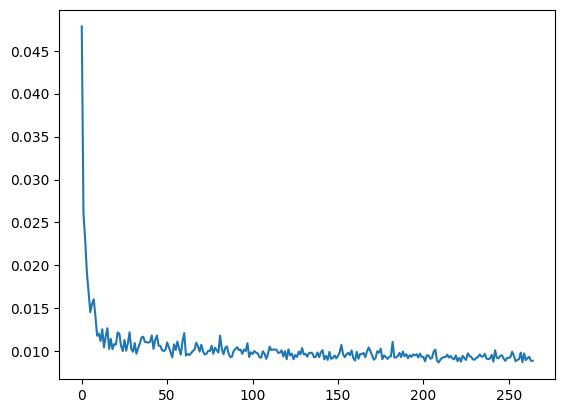

In [50]:
loss = model.history.history['loss']
plt.plot(loss)

In [51]:
testData = df2[trainingDataLen - 60: , :]

In [52]:
xTest = []
yTest = dataset[trainingDataLen:]
for i in range(60, len(testData)):
    xTest.append(testData[i - 60:i, 0])

In [53]:
xTest = np.array(xTest)

In [54]:
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

In [55]:
predictions = model.predict(xTest)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 2s 13ms/step


In [56]:
mape = np.mean(np.abs((yTest - predictions) / yTest)) * 100
print('\nMAPE:' + str(mape))


MAPE:22.187364659884693


#### Visualisasi

In [57]:
print(predictions)

[[1646.1097]
 [1678.9551]
 [1686.7412]
 [1742.1245]
 [1799.2848]
 [1808.5166]
 [1893.2877]
 [1896.7308]
 [1911.0607]
 [1920.559 ]
 [1905.1149]
 [1902.1007]
 [1901.8407]
 [1988.599 ]
 [2020.8531]
 [2030.0945]
 [2029.5396]
 [2085.0842]
 [2119.7188]
 [2122.0786]
 [2173.2434]
 [2153.4983]
 [2229.2612]
 [2260.9644]
 [2213.0422]
 [2281.1003]
 [2259.9702]
 [2193.569 ]
 [2228.7258]
 [2326.5554]
 [2340.6084]
 [2287.1467]
 [2250.8206]
 [2226.0613]
 [2217.141 ]
 [2212.5076]
 [2183.1482]
 [2185.986 ]
 [2247.3667]
 [2266.7627]
 [2235.3328]
 [2177.2778]
 [2167.2676]
 [2241.4038]
 [2245.1663]
 [2206.324 ]
 [2174.2458]
 [2178.3757]
 [2150.956 ]
 [2161.3472]
 [2168.0203]
 [2176.8372]
 [2138.31  ]
 [2137.1145]
 [2185.9146]
 [2241.241 ]
 [2215.4075]
 [2185.5283]
 [2196.7283]
 [2186.318 ]
 [2190.2988]
 [2255.9302]
 [2367.1194]
 [2386.4387]
 [2444.3328]
 [2484.7688]
 [2620.924 ]
 [2729.9507]
 [2757.5847]
 [2726.6736]
 [2687.1997]
 [2686.467 ]
 [2620.3506]
 [2537.9377]
 [2571.1868]
 [2575.6172]
 [2557.1272]

In [58]:
train = df.loc[:trainingDataLen, ['Date', 'Close'] ]
valid = df.loc[trainingDataLen:, ['Date', 'Close'] ]
print('validLength: {}, predictionLength: {}'.format(len(valid), len(predictions)))

validLength: 250, predictionLength: 250


In [59]:
dfPrediction = pd.DataFrame(predictions, columns = ['predictions'])

In [60]:
valid = valid.reset_index()
dfPrediction = dfPrediction.reset_index()

In [61]:
valid = pd.concat([valid, dfPrediction], axis=1)

In [62]:
print(valid)

     index        Date   Close  index  predictions
0     1002  11/29/2021  1690.0      0  1646.109741
1     1003  11/30/2021  1700.0      1  1678.955078
2     1004   12/1/2021  1755.0      2  1686.741211
3     1005   12/2/2021  1810.0      3  1742.124512
4     1006   12/3/2021  1815.0      4  1799.284790
..     ...         ...     ...    ...          ...
245   1247  11/28/2022  3740.0    245  2946.333252
246   1248  11/29/2022  3880.0    246  2945.888672
247   1249  11/30/2022  3870.0    247  2952.072754
248   1250   12/1/2022  3900.0    248  2961.743164
249   1251   12/2/2022  3850.0    249  2967.942627

[250 rows x 5 columns]


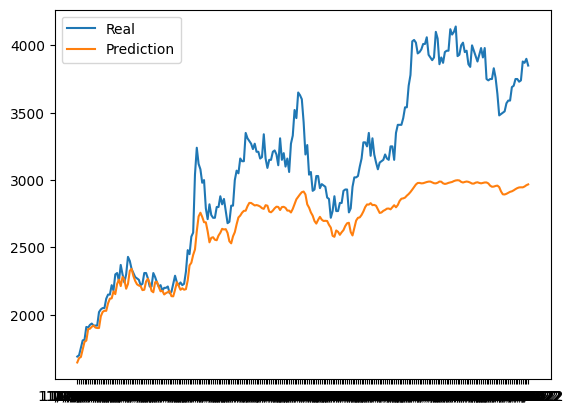

In [63]:
plt.plot(valid['Date'], valid[['Close', 'predictions']])
plt.legend(['Real','Prediction'])

#### Predictions


In [ ]:
for i in range(30):
  x_for_pred = df2[-60:].reshape(1, 60, 1)
  prediction = model.predict(x_for_pred)
  df2 = np.append(df2, prediction)

1/1 [==============================] - 0s 22ms/step


In [ ]:
predictFor30D = df2[-30:]

In [ ]:
predictFor30D = predictFor30D.reshape(-1, 1)
predictFor30D = scaler.inverse_transform(predictFor30D)
predictFor30D

array([[3656.73086286],
       [3554.69388396],
       [3473.90869796],
       [3403.80336285],
       [3342.61988103],
       [3288.66920829],
       [3240.80142796],
       [3198.1282711 ],
       [3159.89395916],
       [3125.42604089],
       [3094.12185162],
       [3065.44622183],
       [3038.93418521],
       [3014.19181198],
       [2990.89225084],
       [2968.77197921],
       [2947.62226224],
       [2927.28227824],
       [2907.63036937],
       [2888.57695878],
       [2870.05788445],
       [2852.02752471],
       [2834.45484012],
       [2817.31858224],
       [2800.60416877],
       [2784.30160046],
       [2768.40358615],
       [2752.90366799],
       [2737.79559642],
       [2723.07291359]])

In [ ]:
import datetime

def date_weekday(from_date, add_days):
    weekday_to_add = add_days
    current_date = from_date
    while weekday_to_add > 0:
        current_date += datetime.timedelta(days=1)
        weekday = current_date.weekday()
        if weekday >= 5:
            continue
        weekday_to_add -= 1
    return current_date

datenow = datetime.date.today()
datePred = []

for x in range (30):
    hariKerja = date_weekday(datenow,1)
    datenow = hariKerja
    datePred.append(hariKerja)

In [ ]:
predictFor30D = pd.DataFrame(predictFor30D, columns = ['Prediction'])

In [ ]:
datePred = pd.DataFrame(datePred, columns = ['Date'])

In [ ]:
datePred = datePred.reset_index()
predictFor30D = predictFor30D.reset_index()

In [ ]:
finalPred = pd.concat([datePred, predictFor30D], axis=1)

In [ ]:
finalPred = finalPred.drop(columns=['index'])

In [ ]:
finalPred

,Date,Prediction
0,2023-06-05,3656.730863
1,2023-06-06,3554.693884
2,2023-06-07,3473.908698
3,2023-06-08,3403.803363
4,2023-06-09,3342.619881
5,2023-06-12,3288.669208
6,2023-06-13,3240.801428
7,2023-06-14,3198.128271
8,2023-06-15,3159.893959
9,2023-06-16,3125.426041


In [ ]:
model.save('ADRO.h5')